In [1]:
import time

from osm_runner import Runner  # pip install osm-runner
import pandas as pd

from arcgis.features import FeatureLayer, GeoAccessor, GeoSeriesAccessor
from arcgis.geoenrichment import enrich
from arcgis import dissolve_boundaries
from arcgis.geometry import project
from arcgis.gis import GIS
from arcgis.features import FeatureLayer, GeoAccessor, GeoSeriesAccessor
from arcgis.geoenrichment import enrich
from arcgis import dissolve_boundaries
from arcgis.geometry import project
from arcgis.gis import GIS
import geopy
from geopy import distance

In [2]:
def str_to_cord(x):
    lat,long = float(x.split(",")[0]),float(x.split(",")[1])
    return lat,long

# Biergarten

In [3]:
import requests
import json
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area["ISO3166-1"="DE"][admin_level=2];
(node["amenity"="biergarten"](area);
 way["amenity"="biergarten"](area);
 rel["amenity"="biergarten"](area);
);
out center;
"""
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
data_biergarten = response.json()

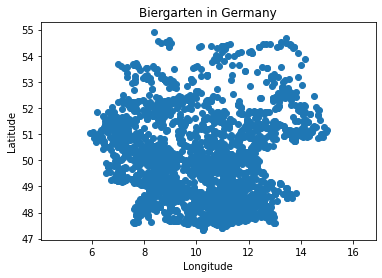

In [4]:
import numpy as np
import matplotlib.pyplot as plt
# Collect coords into list
coords = []
for element in data_biergarten['elements']:
    if element['type'] == 'node':
        lon = element['lon']
        lat = element['lat']
        coords.append((lon, lat))
    elif 'center' in element:
        lon = element['center']['lon']
        lat = element['center']['lat']
        coords.append((lon, lat))
# Convert coordinates into numpy array
X = np.array(coords)
plt.plot(X[:, 0], X[:, 1], 'o')
plt.title('Biergarten in Germany')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.show()

In [5]:
import pandas as pd
df = pd.DataFrame()

In [6]:
df["lat"] = X[:, 1]
df["long"] =X[:, 0]
df["dummy"] = df.lat.apply(lambda x: str(round(x,5)))
df["dummy1"] = df.long.apply(lambda x: "," +str(round(x,5)))
df["dummy2"] = df.dummy+df.dummy1
df["cord"] = df.dummy2.apply(lambda x: str_to_cord(x))
df.drop(["dummy","dummy1","dummy2"],axis =1,inplace=True)

In [7]:
df.head()

,lat,long,cord
0,50.511201,6.993990,"(50.5112, 6.99399)"
1,49.953489,10.875047,"(49.95349, 10.87505)"
2,52.433364,13.190734,"(52.43336, 13.19073)"
3,48.969388,8.390378,"(48.96939, 8.39038)"
4,52.420088,13.176346,"(52.42009, 13.17635)"


In [8]:
dn =pd.read_pickle("d_after_Cafe_OSM.pickle")
#dn= dn[["city","latitude","longitude","park_id","postal_code"]]
dn["dummy"] = dn.latitude.apply(lambda x: str(round(x,5)))
dn["dummy1"] = dn.longitude.apply(lambda x: "," +str(round(x,5)))
dn["dummy2"] = dn.dummy+dn.dummy1
dn["cord"] = dn.dummy2.apply(lambda x: str_to_cord(x))
dn.drop(["dummy","dummy1","dummy2"],axis =1,inplace=True)

In [9]:
def  filter_lat_long(cord,th=0.1):
    la1,ln1 = cord
    dk = df.copy()
    return(
    dk
        [dk["lat"]<=la1+th]
        [dk["lat"]>=la1-th]
        [dk["long"]<=ln1+th]
        [dk["long"]>=ln1-th])


In [10]:
filter_lat_long(dn.cord.iloc[0],th=0.2)

<ipython-input-9-18750887360f>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dk


,lat,long,cord
327,52.571584,13.122969,"(52.57158, 13.12297)"
2042,52.847344,12.894747,"(52.84734, 12.89475)"


In [11]:
def nearest(c,th=0.1):
    dk = filter_lat_long(cord = c,th=th)
    if(len(dk)>0):
        dk["distance"] = dk.cord.apply(lambda x: distance.distance(c,x))
        dk = dk.sort_values("distance",ascending = True)
        v  = dk.distance.iloc[0].km
    else:
        v = 1000
    return v

In [12]:
nearest(dn.cord.iloc[0],th=0.2)

<ipython-input-9-18750887360f>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dk


13.084341423047926

In [13]:
dn["Nearest_Biergarten_km"] = dn.cord.apply(lambda x :nearest(x,th=0.2))

<ipython-input-9-18750887360f>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dk


In [14]:
dn

,park_id,clc_code,area_code,evse_id,datetime_start,datetime_stop,Charging_Started,Charging_Stop,city,latitude,...,day_of_week_name_Start,Precipitation,Temperature,pd,Count_Charging,Charging_time_in_hours_log,cord,Nearest_Bahnhof_km,Nearest_Cafe_km,Nearest_Biergarten_km
0,hj_31c455b8-420e-46af-bce6-436b65ccc416,Suburban,120650165165,hj_DE*BLN*E*174060033,2019-12-17 09:00:13.369,2019-12-17 09:00:13.058,1.0,0.0,Kremmen,52.7596,...,Tuesday,0.0,9.566667,158.737964,58,3.178042,"(52.7596, 13.0239)",7.285195,0.850239,13.084341
1,hj_31c455b8-420e-46af-bce6-436b65ccc416,Suburban,120650165165,hj_DE*BLN*E*174060033,2019-12-17 09:00:13.369,2019-12-17 09:01:16.290,1.0,0.0,Kremmen,52.7596,...,Tuesday,0.0,9.566667,158.737964,58,-4.061555,"(52.7596, 13.0239)",7.285195,0.850239,13.084341
2,hj_31c455b8-420e-46af-bce6-436b65ccc416,Suburban,120650165165,hj_DE*BLN*E*174060033,2019-12-17 09:00:13.369,2019-12-17 09:58:30.703,1.0,0.0,Kremmen,52.7596,...,Tuesday,0.0,9.566667,158.737964,58,-0.029028,"(52.7596, 13.0239)",7.285195,0.850239,13.084341
3,hj_31c455b8-420e-46af-bce6-436b65ccc416,Suburban,120650165165,hj_DE*BLN*E*174060033,2019-12-17 09:58:28.352,2019-12-17 09:00:13.058,1.0,0.0,Kremmen,52.7596,...,Tuesday,0.0,9.566667,158.737964,58,3.136749,"(52.7596, 13.0239)",7.285195,0.850239,13.084341
4,hj_31c455b8-420e-46af-bce6-436b65ccc416,Suburban,120650165165,hj_DE*BLN*E*174060033,2019-12-17 09:58:28.352,2019-12-17 09:01:16.290,1.0,0.0,Kremmen,52.7596,...,Tuesday,0.0,9.566667,158.737964,58,3.137509,"(52.7596, 13.0239)",7.285195,0.850239,13.084341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1940929,sl_23897386,Urban,051120000000,sl_23901984,2021-08-07 19:03:56.000,2021-08-07 16:02:00.000,1.0,0.0,Niestetal,51.3144,...,Saturday,0.0,8.033333,2142.121993,331,3.042987,"(51.3144, 9.5549)",6.690153,0.948615,1.871055
1940930,sl_23897386,Urban,051120000000,sl_23901984,2021-08-07 19:03:56.000,2021-08-07 16:28:29.000,1.0,0.0,Niestetal,51.3144,...,Saturday,0.0,8.033333,2142.121993,331,3.063819,"(51.3144, 9.5549)",6.690153,0.948615,1.871055
1940931,sl_23897386,Urban,051120000000,sl_23901984,2021-08-07 19:03:56.000,2021-08-07 19:55:30.000,1.0,0.0,Niestetal,51.3144,...,Saturday,0.0,8.033333,2142.121993,331,-0.151469,"(51.3144, 9.5549)",6.690153,0.948615,1.871055
1940932,sl_23897386,Urban,051120000000,sl_23901984,2021-08-10 15:29:47.000,2021-08-10 16:57:44.000,1.0,0.0,Niestetal,51.3144,...,Tuesday,0.0,8.033333,2142.121993,331,0.382424,"(51.3144, 9.5549)",6.690153,0.948615,1.871055


In [15]:
dn.to_pickle("d_after_biergarten_OSM.pickle")

In [16]:
dn.to_csv("d_after_biergarten_OSM.csv")